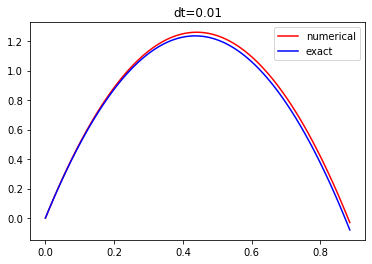

In [2]:
import numpy as np

# ClassName(object) uses the new style class
class ODESolver(object):
    """
    Superclass for numerical methods solving scalar and vector ODEs
      du/dt = f(u, t)
    Attributes:
    t: array of time values
    u: array of solution values (at time points t)
    k: step number of the most recently computed solution
    f: callable object implementing f(u, t)
    """
    def __init__(self, f):
        if not callable(f):
            raise TypeError('f is %s, not a function' % type(f))
        # For ODE systems, f will often return a list, but
        # arithmetic operations with f in numerical methods
        # require that f is an array. Let self.f be a function
        # that first calls f(u,t) and then ensures that the
        # result is an array of floats.
        self.f = lambda u, t: np.asarray(f(u, t), float)

    def advance(self):
        """Advance solution one time step."""
        raise NotImplementedError

    def set_initial_condition(self, U0):
        if isinstance(U0, (float,int)):  # scalar ODE
            self.neq = 1
            U0 = float(U0)
        else:                            # system of ODEs
            U0 = np.asarray(U0)          # (assume U0 is sequence)
            self.neq = U0.size
        self.U0 = U0

        # Check that f returns correct length:
        try:
            f0 = self.f(self.U0, 0)
        except IndexError:
            raise IndexError('Index of u out of bounds in f(u,t) func. Legal indices are %s' % (str(range(self.neq))))
        if f0.size != self.neq:
            raise ValueError('f(u,t) returns %d components, while u has %d components' % (f0.size, self.neq))

    def solve(self, time_points, terminate=None):
        """
        Compute solution u for t values in the list/array
        time_points, as long as terminate(u,t,step_no) is False.
        terminate(u,t,step_no) is a user-given function
        returning True or False. By default, a terminate
        function which always returns False is used.
        """
        if terminate is None:
            terminate = lambda u, t, step_no: False

        if isinstance(time_points, (float,int)):
            raise TypeError('solve: time_points is not a sequence')
        self.t = np.asarray(time_points)
        if self.t.size <= 1:
            raise ValueError('ODESolver.solve requires time_points array with at least 2 time points')

        n = self.t.size
        if self.neq == 1:  # scalar ODEs
            self.u = np.zeros(n)
        else:              # systems of ODEs
            self.u = np.zeros((n,self.neq))

        # Assume that self.t[0] corresponds to self.U0
        self.u[0] = self.U0

        # Time loop
        for k in range(n-1):
            self.k = k
            self.u[k+1] = self.advance()
            if terminate(self.u, self.t, self.k+1):
                break  # terminate loop over k
        return self.u[:k+2], self.t[:k+2]


class ForwardEuler(ODESolver):
    def advance(self):
        u, f, k, t = self.u, self.f, self.k, self.t
        dt = t[k+1] - t[k]
        u_new = u[k] + dt*f(u[k], t[k])
        return u_new
    
class RungeKutta4(ODESolver):
    def advance(self):
        u, f, k, t = self.u, self.f, self.k, self.t
        dt = t[k+1] - t[k]
        dt2 = dt/2.0
        K1 = dt*f(u[k], t[k])
        K2 = dt*f(u[k] + 0.5*K1, t[k] + dt2)
        K3 = dt*f(u[k] + 0.5*K2, t[k] + dt2)
        K4 = dt*f(u[k] + K3, t[k] + dt)
        u_new = u[k] + (1/6.0)*(K1 + 2*K2 + 2*K3 + K4)
        return u_new

import sys, os

class Derivative:
    def __init__(self, f, h=1E-9):
        self.f = f
        self.h = float(h)

    def __call__(self, x):
        f, h = self.f, self.h      # make short forms
        return (f(x+h) - f(x-h))/(2*h)


registered_solver_classes = [
    ForwardEuler, RungeKutta4]

def test_exact_numerical_solution():
    a = 0.2; b = 3

    def f(u, t):
        return a + (u - u_exact(t))**5

    def u_exact(t):
        """Exact u(t) corresponding to f above."""
        return a*t + b

    U0 = u_exact(0)
    T = 8
    n = 10
    tol = 1E-15
    t_points = np.linspace(0, T, n)
    for solver_class in registered_solver_classes:
        solver = solver_class(f)
        solver.set_initial_condition(U0)
        u, t = solver.solve(t_points)
        u_e = u_exact(t)
        max_error = (u_e - u).max()
        msg = '%s failed with max_error=%g' % \
              (solver.__class__.__name__, max_error)
        assert max_error < tol, msg

# if __name__ == '__main__':
test_exact_numerical_solution()
    
    
# test the code for the trajectory of a ball   

from math import pi
from math import cos
from math import sin
from math import tan
from numpy import linspace
from matplotlib.pyplot import *

def f(u, t):
    x, vx, y, vy = u
    g = 9.81
    return [vx, 0, vy, -g]

v0 = 5
theta = 80*pi/180
U0 = [0, v0*cos(theta), 0, v0*sin(theta)]
T = 1.2; dt = 0.01; n = int(round(T/dt))
solver = ForwardEuler(f)
solver.set_initial_condition(U0)



def terminate(u, t, step_no):
    y = u[:,2]                   # all the y coordinates
    return y[step_no] < 0

u, t = solver.solve(linspace(0, T, n+1), terminate)
x = u[:,0]  # or array([x for x, vx, y, vy in u])
y = u[:,2]  # or array([y for x, vx, y, vy in u])



def exact(x):
    g = 9.81
    y0 = U0[2]  # get y0 from the initial values
    return x*tan(theta) - g*x**2/(2*v0**2)*1/(cos(theta))**2 + y0

plot(x, y, 'r', x, exact(x), 'b')
legend(('numerical', 'exact'))
title('dt=%g' % dt)
savefig('tmp_ball.pdf')
show()